Conforme mostra o workflow geral do active learning, apresentado no diagrama abaixo, o algoritmo começa a partir de um conjunto de dados não rotulados. Dos quais um número muito pequeno deles é rotulado. O modelo de aprendizado de máquina começa a aprender com esse pequeno conjunto e seleciona o próximo ponto de dados para ser rotulado. 

Dessa forma, o modelo de ML pode escolher os pontos de dados mais informativos para os quais pode haver incerteza na previsão. 

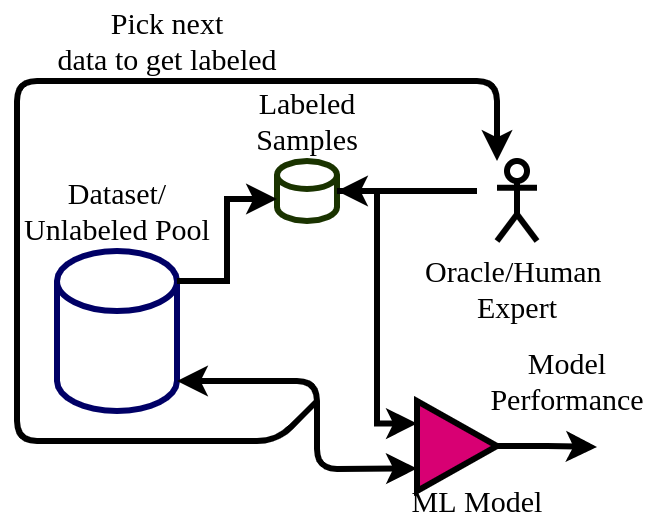

# Geração de dataset sintético com duas classes


*   Classe A
*   Classe B



In [ ]:
!pip install numpy==1.21.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importação de bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [ ]:
# Definição de constantes para visualização posterior dos dados e resultados
labelsize   = 12
width       = 5
height      = 4
  
plt.rc('font', family ='serif')
plt.rc('text', usetex = True)
plt.rc('xtick', labelsize = labelsize)
plt.rc('ytick', labelsize = labelsize)
plt.rc('axes', labelsize = labelsize)

In [ ]:
Class1N = 100
 
# Geraçãde 100 amostras com distribuição normal com média = 1 e dp = 1 para formar x1 e x2 
x1 = np.random.normal(0, 1, Class1N)
x2 = np.random.normal(0, 1, Class1N)

# juntando as sequências de matrizes acima ao longo de um novo eixo
# axis = 0 (empilhanmento vertical) e axis = 1 (empilhanmento horizontal)
X = np.stack((x1, x2), axis=1) # shape(X) = (100,2)

In [ ]:
T1 = np.asarray([[1, 0.5],[0.4,1]]) # shape(T1) = (2,2)
X_t1 = np.matmul(X,T1) # produto das matrizes X e T1 -> (100,2)*(2,2) -> shape(X_t1) = (100,2)
X_t2 = np.copy(X_t1) # cópia da matriz X_t1
X_t2[:,0]+=3  # todos os elementos númericos da primeira coluna da matriz X_t2 são incrementados em 3

In [ ]:
X = np.vstack((X_t1, X_t2)) # Empilha as matrizes X_t1 e X_t2 em sequência verticalmente (linhas) -> shape(X)=200x2
y = np.append(np.ones((Class1N)),np.zeros((Class1N))) # Definição de variável com os 100 primeiros valores númericos iguais a 1 e os 100 últimos valores númericos iguais a 0 -> shape(y) = (200x2)
X_t = np.column_stack((X, y)) # Empilha as matrizes X e y em sequência de colunas -> shape(X_t) = (200,3)
np.random.shuffle(X_t) # todos os valores de X_t são embaralhados aleatoriamente

In [ ]:
# Salva matriz X_t (dados gerados) em um arquivo csv
data = pd.DataFrame(X_t, columns = ['x1','x2','label'])
data.to_csv('/content/data.csv')

In [ ]:
# Visualização das 5 primeiras linhas do arquivo csv
syntdata = pd.read_csv("/content/data.csv")
syntdata[:]

In [ ]:
# Definição de features e labels
# As duas primeiras colunas são as features e última representa a label (binária)
features = data.values[:,:-1] #duas primeiras colunas 
labels = data.values[:,-1] #última coluna

In [ ]:
# Necessária instalação dos pacotes abaixo para plotar o gráfico a seguir. 
# Veja mais: https://stackoverflow.com/questions/55746749/latex-equations-do-not-render-in-google-colaboratory-when-using-matplotlib
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [ ]:
!mkdir /content/Results
fig1, ax = plt.subplots()
scatter = plt.scatter(features[:,0], features[:,1], c=labels)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes")
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()
fig1.set_size_inches(width, height)
fig1.savefig('/content/Results/plot.png', dpi=200)


# Passive Learning - Ramdom Sampling:
O classificador começa com 10 pontos de dados rotulados. Após cada iteração, ele pega mais 1 do pool aleatoriamente (dados não rotulados) e o adiciona ao pool rotulado. O modelo é treinado no novo conjunto rotulado e a precisão é calculada em relação ao conjunto de dados de teste.

In [ ]:
# Importação de bibliotecas necessárias
import numpy as np
import pandas as pd
from tqdm import tqdm
from numpy import save
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [ ]:
# Definição de constantes para visualização posterior dos dados e resultados
labelsize   = 12
width       = 6
height      = 4
  
plt.rc('font', family ='serif')
plt.rc('text', usetex = True)
plt.rc('xtick', labelsize = labelsize)
plt.rc('ytick', labelsize = labelsize)
plt.rc('axes', labelsize = labelsize)

In [ ]:
# Lendo dados do arquivo csv criado anteriormente
data = pd.read_csv('/content/data.csv').values
y = data[:,-1] # última coluna (label)
X = data[:,:-1] # duas primeiras colunas (features)

In [ ]:
# Definição de constantes úteis em trechos de código posteriores
numDataTotal = 140
labeledPoolN = 10
batchSz = 1
 
nAccs = (numDataTotal-labeledPoolN)//batchSz # floor division

monteN = 100

In [ ]:
# função para computar a acurácia 
def computeAccuracy(dataL):
    y_trainC = dataL[:,-1]
    X_trainC = dataL[:,1:-1]
    LRC = LogisticRegression() # instância do modelo
    LRC.fit(X_trainC, y_trainC) # treinamento do modelo
    y_pred = LRC.predict(X_test[:,1:]) # realiza predições sobre a segunda coluna de X_test
    Acc = accuracy_score(y_test, y_pred) # calcula acúracia da predição 
    return np.array([[Acc]]), LRC 

In [ ]:
def getBatch(dataPool, batchSz):
    dataBatch = dataPool[np.random.choice(dataPool.shape[0], batchSz, replace=False), :] # seleção aleatória de um datapoint

    # Verifica se os elementos da primeira coluna de dataBatch (índices dos datapoints) estão presentes na primeira coluna de dataPool
    # O retorno é um array booleano com mesmo shape de dataPool[:0], sendo False se o elemento 
    # existir em ambos ou True, caso contrário (invert = True).

    remIdx = np.isin(dataPool[:,0], dataBatch[:,0], invert=True)

    # atualiza o dataPool, desconsiderando o datapoint seleionado na primeira linha da função
    dataPool = dataPool[remIdx]

    return dataBatch, dataPool

# exemplo para rápida assimilação da função:

# print(dataPool[:3]) - considerando apenas três linhas do DataPool:
#  [[170.           3.11192148   0.49846787   0.        ]
#  [182.           0.39528966   0.25007856   1.        ]
#  [ 59.           3.41098947   1.3546939    0.        ]]

# print(dataBatch) - considerando apenas três linhas do DataPool:
# [[170.           3.11192148   0.49846787   0.        ]]

# print(dataPool[:,0]) - considerando apenas três linhas do DataPool:
# [170. 182.  59.]

# print(dataBatch[:,0]):
# [170.]

# print(remIdx):
# [False  True  True]

# print(dataPool)
#  [[182.           0.39528966   0.25007856   1.        ]
#  [ 59.           3.41098947   1.3546939    0.        ]]

In [ ]:
accuracySmooth = []

# definição de 30% dos dados para teste e 70% para treinamento (entrada = X e saída = y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=5)
 
# tqdm: apresenta progress bar ao executar o código [0/100] - 100 iterações
for monte in tqdm(range(monteN)):
    
    # empilhamento de X_train e y_train horizontalmente (ou seja, em coluna) para fazer uma única matriz
    # shape X_train=(140,3) || shape y_train=(140,) || shape (np.atleast_2d(y_train).T)=(140,1)
    dataPool = np.hstack((X_train, np.atleast_2d(y_train).T)) # -> shape(dataPool) = (140,4)

    # formação do datapool (labeled data points)
    # seleção de 10 labbed datapoins do datapool 
    # dataPool.shape[0] = 140
    # labeledPoolN = 10 (datapoints selecionados)
    # replace=False (o mesmo datapoint não pode ser selecionado mais de uma vez)
    # A variável dataPoolL recebe a matriz com 10 amostras aleatórias
    dataPoolL = dataPool[np.random.choice(dataPool.shape[0], labeledPoolN, replace=False), :]

    # Verifica se os elementos da primeira coluna de dataPoolL estão presentes na primeira coluna de dataPool
    # O retorno é um array booleano com mesmo shape de dataPool[:0], sendo False se o elemento 
    # existir em ambos ou True, caso contrário (invert = True).
    remIdx = np.isin(dataPool[:,0], dataPoolL[:,0], invert=True)
 
    # atualização de dataPool (unlabeled datapoints)
    dataPool = dataPool[remIdx]
    
    # inicialização da variável que armazenará a precisão calculada [0 linhas e 1 elemento por linha - tipo float] -> inicialização vazia
    AccuracyRes = np.empty((0,1), float)
 
    # accStart = acurácia inicial calculada para 10 labeled datapoints
    # cModel = instância do modelo (Regressão logística)
    accStart, cModel = computeAccuracy(dataPoolL)

    # empilhamento vertical das acurácias calculadas  
    AccuracyRes = np.append(AccuracyRes, accStart, axis=0) 
 
    for i in range(nAccs):
        dataBatch, dataPool = getBatch(dataPool, batchSz)
        dataPoolL = np.vstack((dataPoolL, dataBatch)) # adiciona o novo datapoint ao dataPoolL (labeled data points)
        
        # cAcc = acurácia inicial calculada 
        # cModel = instância do modelo (Regressão logística)
        cAcc, cModel = computeAccuracy(dataPoolL)

        # empilhamento vertical das acurácias calculadas 
        AccuracyRes = np.append(AccuracyRes, cAcc, axis=0)
    accuracySmooth.append(AccuracyRes) 

accuracySmooth = np.asarray(accuracySmooth) # converte accuracySmooth em um array
accuracySmooth = np.mean(accuracySmooth, axis=0) # cálculo da média das acurácias

fig1 = plt.figure()
plt.plot([x for x in range(labeledPoolN, numDataTotal+1, batchSz)], accuracySmooth)
plt.xlabel('número de amostras')
plt.ylabel('mean accuracy')
plt.show()

fig1.savefig('/content/Results/RandomSampling.png', dpi=200)
 
 
graphData = np.array(([x for x in range(labeledPoolN, numDataTotal+1, batchSz)], accuracySmooth.flatten()))
save('/content/Results/RandomSampling.npy', graphData)

# Active Learning - Uncertainty Sampling (Entropia): 

O classificador começa com 10 pontos de dados rotulados. Após cada iteração, ele seleciona mais 1 do pool (dados não rotulados) com base na amostragem de incerteza e o adiciona aos dados rotulados (train dataset). O modelo é treinado no novo conjunto rotulado e a precisão é calculada em relação ao conjunto de dados de teste.

In [ ]:
# Importação de bibliotecas necessárias
import numpy as np
import pandas as pd
from tqdm import tqdm
from numpy import save
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [ ]:
# Definição de constantes para visualização posterior dos dados e resultados
labelsize   = 12
width       = 6
height      = 4
  
plt.rc('font', family ='serif')
plt.rc('text', usetex = True)
plt.rc('xtick', labelsize = labelsize)
plt.rc('ytick', labelsize = labelsize)
plt.rc('axes', labelsize = labelsize)

In [ ]:
# Lendo dados do arquivo csv criado anteriormente
data = pd.read_csv('/content/data.csv').values
y = data[:,-1] # última coluna (label)
X = data[:,:-1] # duas primeiras colunas (features)

In [ ]:
# Definição de constantes úteis em trechos de código posteriores
numDataTotal = 140
labeledPoolN = 10
nAccs = numDataTotal-labeledPoolN+1
 
monteN = 100

In [ ]:
# função para computar a acurácia 
def computeAccuracy(dataL):
    y_trainC = dataL[:,-1]
    X_trainC = dataL[:,1:-1]
    LRC = LogisticRegression() # instância do modelo
    LRC.fit(X_trainC, y_trainC) # treinamento do modelo
    y_pred = LRC.predict(X_test[:,1:]) # realiza predições sobre a segunda coluna de X_test
    Acc = accuracy_score(y_test, y_pred) # calcula acúracia da predição 
    return np.array([[Acc]]), LRC  

In [ ]:
def getBestDpoint(dataPool, cModel):
  # inicialização da matriz  que armazenará a entropia calculada a seguir [0 linhas e 2 elementos por linha - tipo float] -> inicialização vazia
    entropyVector = np.empty((0,2), float) 
   
    for row in dataPool:
        
        trow = row[1:-1].reshape(1,-1) # extração das colunas de features
        # print(trow)
        # fornece o logaritmo das probabilidades, isso geralmente é mais prático, pois as probabilidades podem se tornar muito, muito pequenas
        logP = cModel.predict_log_proba(trow)[0]

        # método que retorna as probabilidades de cada classe para cada datapoint
        prob = cModel.predict_proba(trow)[0]

        # cálculo da entropia (active learning method)
        # A entropia é a medida da incerteza de uma variável aleatória
        # Valores mais altos de entropia indicam maior incerteza na distribuição de probabilidade [1]. 
        # Em cada etapa do active learning, para cada exemplo não rotulado no conjunto de treinamento, 
        # o algoritmo de aprendizado ativo calcula a entropia sobre as probabilidades de classe previstas e seleciona o exemplo com a maior entropia. 
        # O exemplo com a maior entropia é o exemplo para o qual o classificador tem menos certeza sobre sua pertinência à classe.
        entropy = -1*np.sum(np.multiply(prob, logP))

        # Armazenamento fos índices de cada datapoint e as entralpias calculadas
        entropyVector = np.append(entropyVector, np.array([[row[0], entropy]]), axis=0) 
    
    imax = np.argmax(entropyVector[:,1]) # Retorna o índice do valor máximo das entralpias calculadas
    indexUncertain = entropyVector[imax][0] # Retorna o índice (número) do datapoint 
    bestDataPoint = dataPool[dataPool[:,0]==indexUncertain, :] # Retorna o datapoint que foi selecionado para ser inserido no próximo conjunto de daos rotulados
    return bestDataPoint

# exemplo para rápida assimilação da função:

# print(dataPool[:3]) - considerando apenas três linhas do DataPool:
#   [[170.           0.50268923   0.4531986    1.        ]
#    [182.           4.36350871   1.01432935   0.        ]
#   [ 59.           3.56341734   0.33804564   0.        ]]

# print(trow) - considerando apenas três linhas do DataPool:
#   [[0.50268923 0.4531986 ]]
#   [[4.36350871 1.01432935]]
#   [[3.56341734 0.33804564]]

# print(entropyVector) - considerando apenas três linhas do DataPool:
#   [[170.           0.50131769]
#   [182.           0.2237909 ]
#   [ 59.           0.29066336]]

# entropyVector[:,1] = [0.50131769 0.2237909  0.29066336]
# print(imax) = 0

# print(indexUncertain) = 170

# print(bestDataPoint) - o datapoint de maior entropia deve ser selecionado:
#   [[170.           0.50268923   0.4531986    1.        ]]

In [ ]:
accuracySmooth = []

# definição de 30% dos dados para teste e 70% para treinamento (entrada = X e saída = y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=5)

# tqdm: apresenta progress bar ao executar o código [0/200] - 200 iterações
for monte in tqdm(range(monteN)):

  # empilhamento de X_train e y_train horizontalmente (ou seja, em coluna) para fazer uma única matriz
  # shape X_train=(140,3) || shape y_train=(140,) || shape (np.atleast_2d(y_train).T)=(140,1)
  dataPool = np.hstack((X_train, np.atleast_2d(y_train).T)) # -> shape(dataPool) = (140,4)
  
  # formação do datapool (labeled data points)
  # seleção de 10 labbed datapoins do datapool 
  # dataPool.shape[0] = 140
  # labeledPoolN = 10 (datapoints selecionados)
  # replace=False (o mesmo datapoint não pode ser selecionado mais de uma vez)
  # A variável dataPoolL recebe a matriz com 10 amostras aleatórias
  dataPoolL = dataPool[np.random.choice(dataPool.shape[0], labeledPoolN, replace=False), :]

  # Verifica se os elementos da primeira coluna de dataPoolL estão presentes na primeira coluna de dataPool
  # O retorno é um array booleano com mesmo shape de dataPool[:0], sendo False se o elemento 
  # existir em ambos ou True, caso contrário (invert = True).
  remIdx = np.isin(dataPool[:,0], dataPoolL[:,0], invert=True)

  # atualização de dataPool, agora com 10 datapoints a menos
  dataPool = dataPool[remIdx]
 
  # inicialização da variável que armazenará a precisão calculada [0 linhas e 1 elemento por linha - tipo float] -> inicialização vazia
  AccuracyRes = np.empty((0,1), float)

  # accStart = acurácia inicial calculada para 10 labeled datapoints
  # cModel = instância do modelo (Regressão logística)
  accStart, cModel = computeAccuracy(dataPoolL)

  # empilhamento vertical das acurácias calculadas 
  AccuracyRes = np.append(AccuracyRes, accStart, axis=0) 

  # Ao longo de 130 iterações, faça:
  for i in range(numDataTotal-labeledPoolN):
      dataPointUncertain = getBestDpoint(dataPool, cModel) # retorna o datapoint de maior entropia 
      dataPoolL = np.vstack((dataPoolL, dataPointUncertain)) # adiciona o novo datapoint ao dataPoolL (labeled data points)

      # Verifica se os elementos da primeira coluna de dataPoolL estão presentes na primeira coluna de dataPool
      # O retorno é um array booleano com mesmo shape de dataPool[:0], sendo False se o elemento 
      # existir em ambos ou True, caso contrário (invert = True).
      remIdx2 = np.isin(dataPool[:,0], dataPoolL[:,0], invert=True)

      # atualização de dataPool (unlabeled datapoints)
      dataPool = dataPool[remIdx2]

      # cAcc = acurácia inicial calculada 
      # cModel = instância do modelo (Regressão logística)
      cAcc, cModel = computeAccuracy(dataPoolL)

      # empilhamento vertical das acurácias calculadas 
      AccuracyRes = np.append(AccuracyRes, cAcc, axis=0) 
  accuracySmooth.append(AccuracyRes) 

accuracySmooth = np.asarray(accuracySmooth) # converte accuracySmooth em um array
accuracySmooth = np.mean(accuracySmooth, axis=0) # cálculo da média das acurácias
 
 
fig2 = plt.figure()
plt.plot([x for x in range(labeledPoolN, nAccs+labeledPoolN)], accuracySmooth)
plt.xlabel('número de amostras')
plt.ylabel('mean accuracy')
plt.show()
fig2.savefig('/content/Results/Active_Learning_Entropy.png', dpi=200)
 
graphData = np.array(([x for x in range(labeledPoolN, nAccs+labeledPoolN)], accuracySmooth.flatten()))
save('/content/Results/Active_Learning_Entropy.npy', graphData)


# Comparação e visualização dos resultados

In [ ]:
# Importação de bibliotecas necessárias
!pip install numpy==1.16.1 #downgrade necessário para importar ps arquivos numpy salvos nas seções anteriores. Mais informações: https://stackoverflow.com/questions/55890813/how-to-fix-object-arrays-cannot-be-loaded-when-allow-pickle-false-for-imdb-loa
import numpy as np
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Definição de constantes para visualização posterior dos dados e resultados
labelsize   = 12
width       = 6
height      = 4
  
plt.rc('font', family ='serif')
plt.rc('text', usetex = True)
plt.rc('xtick', labelsize = labelsize)
plt.rc('ytick', labelsize = labelsize)
plt.rc('axes', labelsize = labelsize)

In [ ]:
data1 = np.load('/content/Results/RandomSampling.npy')
data2 = np.load('/content/Results/Active_Learning_Entropy.npy')

In [ ]:
fig, ax = plt.subplots()
fig.subplots_adjust(left=.2, bottom=.2, right=.97, top=.90)

 
# plt.axhline(y=1, color='r', linestyle='--', label='Peak Performance')
plt.plot(data1[0],data1[1], label ='RandomSampling',color = 'blue', linewidth=1, linestyle='-')
plt.plot(data2[0],data2[1], label ='US - Entropia',color = 'red', linewidth=1, linestyle='dashed')
# plt.plot(data3[0],data3[1], label ='AL US')
 
# ax.legend(bbox_to_anchor=(1, 0), loc='lower right')
ax.legend(loc='lower right')
 
plt.xlabel('Número de amostras')
plt.ylabel('mean accuracy')
plt.show()
 
fig.set_size_inches(width, height)
fig.savefig('/content/Results/Exp_Results.png', dpi=200)
plt.close()